In [1]:
from jetutils.jet_finding import JetFindingExperiment
from jetutils.definitions import DATADIR, compute, xarray_to_polars, get_region, labels_to_mask
from jetutils.plots import Clusterplot, COLORS
from jetutils.data import DataHandler, open_dataset, compute_anomalies_pl, coarsen_da, extract, smooth
from jetutils.clustering import Experiment
from jetutils.anyspell import mask_from_spells_pl, get_persistent_spell_times_from_som
import colormaps

import numpy as np
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pathlib import Path
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  122880


In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical")
ds = open_dataset(basepath.joinpath("ds.zarr"))
ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")
da_s = compute(ds["s"], progress_flag=True)
dh = DataHandler.from_basepath_and_da(basepath.joinpath("results"), ds["s"])
exp = Experiment(dh)

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year"), pl.col("member")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "1d"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "1d"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "1d"),
    ).drop("year", "start", "end")
    return [seasons[["member", season]].explode(season).sort("member", season) for season in ["spring", "summer", "autumn"]]

In [4]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
members = summer["member"].unique().sort().to_numpy()
index = summer.to_pandas().set_index(["member", "summer"]).index
summer_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, summer_da, save_da=False)
exp_summer = Experiment(dh_summer)
net_summer, centers_summer, labels_summer = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")
mask = labels_to_mask(labels_summer, as_da=True)
populations_summer = net_summer.compute_populations()
coords = net_summer.neighborhoods.coordinates

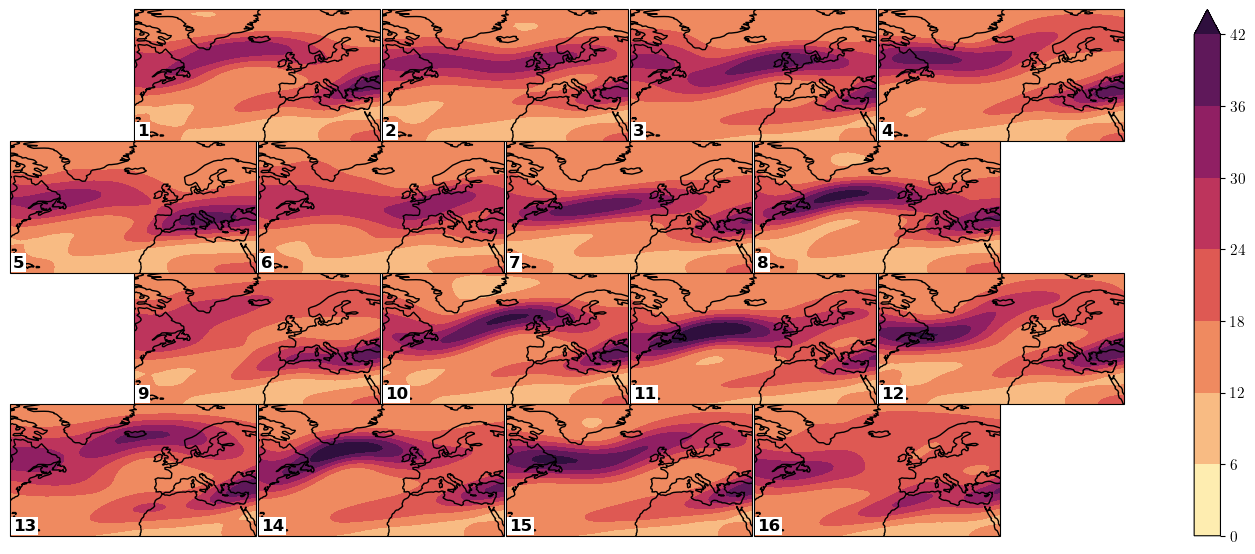

In [5]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers_summer, cmap=colormaps.matter, levels=7)

In [7]:
labels_summer

<xarray.DataArray 'labels' (megatime: 191593)> Size: 2MB
array([15, 15, 15, ..., 15, 11, 12])
Coordinates:
  * megatime  (megatime) object 2MB MultiIndex
  * member    (megatime) <U12 9MB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time      (megatime) datetime64[ns] 2MB 1970-06-26T12:00:00 ... 2009-10-0...

In [11]:
labels_summer.isel(megatime=(labels_summer.member == labels_summer.member[0]))

<xarray.DataArray 'labels' (megatime: 3762)> Size: 30kB
array([15, 15, 15, ..., 15, 15, 15])
Coordinates:
  * megatime  (megatime) object 30kB MultiIndex
  * member    (megatime) <U12 181kB 'r10i1181p1f1' ... 'r10i1181p1f1'
  * time      (megatime) datetime64[ns] 30kB 1970-06-26T12:00:00 ... 2009-10-...

In [22]:
from sklearn.metrics import pairwise_distances
from jetutils.anyspell import _get_persistent_spell_times_from_som
dists = pairwise_distances(net_summer.weights)
spells = get_persistent_spell_times_from_som(labels_summer, dists, 0, 8, nt_before=20, nojune=False)

# labels_daily = labels_summer.sel(time=labels_summer.time.dt.hour == 0)
# mask_daily = labels_to_mask(labels_daily)

# spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
# spells_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

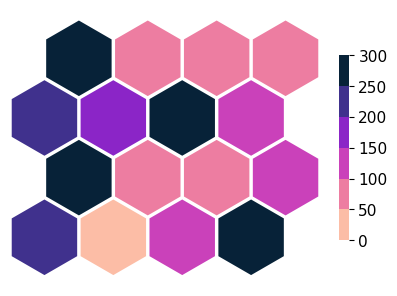

In [24]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

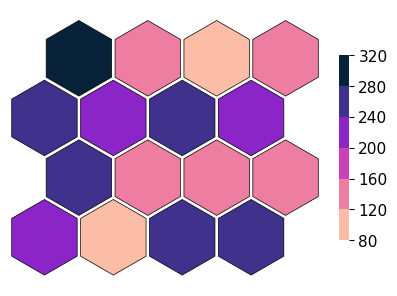

In [25]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

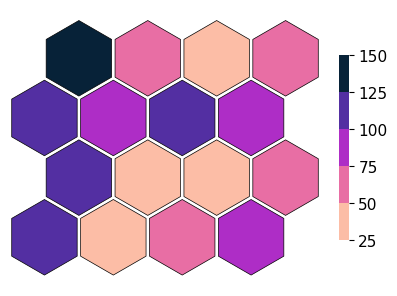

In [26]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

# trans matrix shenanigans

In [ ]:
spells = get_persistent_spell_times_from_som(
    labels_summer, dists, 0, 8, nt_before=1, nojune=False, daily=False
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})
spells_any = get_persistent_spell_times_from_som(
    labels_summer, dists, 0, 1, nt_before=1, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)

value,time,member
i64,list[datetime[ms]],list[str]
15,"[1979-05-31 12:00:00, 1979-06-01 12:00:00, … 1979-06-26 12:00:00]","[""r8i1251p1f1"", ""r8i1251p1f1"", … ""r8i1251p1f1""]"
12,"[2006-09-04 12:00:00, 2006-09-05 12:00:00, … 2006-09-29 12:00:00]","[""r6i1251p1f1"", ""r6i1251p1f1"", … ""r6i1251p1f1""]"
0,"[1996-06-27 12:00:00, 1996-06-28 12:00:00, … 2000-08-07 12:00:00]","[""r10i1231p1f1"", ""r10i1231p1f1"", … ""r10i1301p1f1""]"
3,"[1976-08-11 12:00:00, 1976-08-12 12:00:00, … 2007-07-18 12:00:00]","[""r2i1301p1f1"", ""r2i1301p1f1"", … ""r3i1251p1f1""]"
6,"[1971-08-25 12:00:00, 1971-08-26 12:00:00, … 1971-09-16 12:00:00]","[""r9i1281p1f1"", ""r9i1281p1f1"", … ""r9i1281p1f1""]"
…,…,…
5,"[2008-07-18 12:00:00, 2008-07-19 12:00:00, … 2008-08-08 12:00:00]","[""r4i1251p1f1"", ""r4i1251p1f1"", … ""r4i1251p1f1""]"
11,"[1970-07-12 12:00:00, 1970-07-13 12:00:00, … 1970-07-29 12:00:00]","[""r6i1301p1f1"", ""r6i1301p1f1"", … ""r6i1301p1f1""]"
2,"[1986-09-12 12:00:00, 1986-09-13 12:00:00, … 1986-09-29 12:00:00]","[""r3i1251p1f1"", ""r3i1251p1f1"", … ""r3i1251p1f1""]"


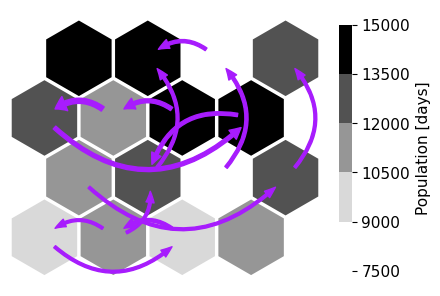

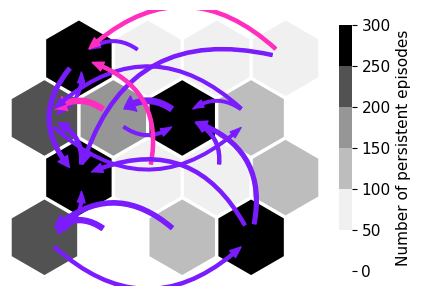

In [38]:
import matplotlib.patches as patches
import polars.selectors as cs
from itertools import product
# What happens before?
spells = get_persistent_spell_times_from_som(
    labels_summer, dists, 0, 8, nt_before=1, nojune=False, daily=False
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})
spells_any = get_persistent_spell_times_from_som(
    labels_summer, dists, 0, 1, nt_before=1, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)
longest_spell = (
    spells.group_by("value")
    .agg(
        pl.col("time").filter(pl.col("len") == pl.col("len").max()),
        pl.col("member").filter(pl.col("len") == pl.col("len").max())
    )
    ## allows for duplicates, I think it's fine
    .explode("member", "time")
    .join(spells, on=["value", "member", "time"])
    .sort("value", "member", "time")
)

labels_masked = spells.join(
    xarray_to_polars(labels_summer).cast({"time": pl.Datetime("ms")}), on=["member","time"]
)
labels_any_masked = spells_any.join(
    xarray_to_polars(labels_summer).cast({"time": pl.Datetime("ms")}), on=["member","time"]
)
labels_longest_masked = longest_spell.join(
    xarray_to_polars(labels_summer).cast({"time": pl.Datetime("ms")}), on=["member","time"]
)
rel_ind = -1
index = pl.int_range(0, 16, eager=True).rename("labels").to_frame()
transitions_any = index.clone()
transitions_spell = index.clone()
transitions_longest = index.clone()

for i in range(16):
    a = labels_any_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_any = transitions_any.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_masked.filter(pl.col("value") == i, pl.col("relative_index") == rel_ind)[
        "labels"
    ].value_counts(sort=True)
    transitions_spell = transitions_spell.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_longest_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_longest = transitions_longest.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )

## spells per cluster

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net_summer.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_any_ = transitions_any.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net_summer.plot_on_map(
    populations_summer,
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Population [days]"},
)
thresh = 0.2
arrowcount = 0
for i, j in product(range(16), range(16)):
    if i == j:
        continue
    strength = transitions_any_.fill_null(0)[i, f"trans to {j}"]
    if strength < thresh:
        continue
    arrowcount += 1
    tail_width = ((strength - thresh + 1) * 1.2) ** 3.6
    head_width = tail_width * 3
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=COLORS[0],
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[j], **kw))
## spells per cluster

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net_summer.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_spell_ = transitions_spell.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net_summer.plot_on_map(
    spells_per_cluster["len"].to_numpy(),
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Number of persistent episodes"},
)
thresh = 0.2
arrowcount = 0
for i, j in product(range(16), range(16)):
    if i == j:
        continue
    strength = transitions_spell_.fill_null(0)[i, f"trans to {j}"]
    if strength < thresh:
        continue
    is_longest = transitions_longest[i, f"trans to {j}"] is not None
    arrowcount += 1
    tail_width = ((strength - thresh + 1) * 1.2) ** 3.0
    head_width = tail_width * 3
    color = COLORS[2] if is_longest else COLORS[1]
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=color,
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[j], **kw))

In [ ]:
transitions_spell.with_columns(sum=pl.sum_horizontal(cs.contains("trans")))


labels,trans to 0,trans to 1,trans to 2,trans to 3,trans to 4,trans to 5,trans to 6,trans to 7,trans to 8,trans to 9,trans to 10,trans to 11,trans to 12,trans to 13,trans to 14,trans to 15,sum
i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,null,5,null,14,27,2,6,5,59,5,null,21,14,3,null,1,162
1,34,null,2,13,7,26,9,17,13,2,5,5,null,1,10,4,148
2,3,6,null,null,null,9,7,2,1,null,11,null,13,4,8,11,75
3,54,10,null,null,4,null,null,3,53,1,null,14,16,5,20,4,184
4,35,1,null,4,null,22,27,37,27,1,null,12,null,null,null,4,170
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11,27,2,null,17,6,null,18,11,30,15,7,null,15,2,24,3,177
12,4,null,3,7,null,1,null,null,23,1,null,12,null,5,17,28,101
13,15,1,5,2,null,null,1,5,5,8,7,4,68,null,9,15,145


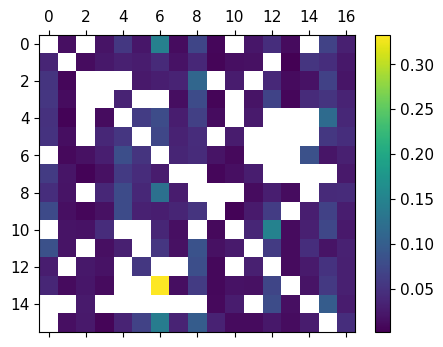

In [48]:
im = plt.matshow((transitions_spell.with_columns(sum=pl.sum_horizontal(cs.contains("trans"))) / transitions_any.with_columns(sum=pl.sum_horizontal(cs.contains("trans")))).select(cs.exclude("labels")).to_numpy())
plt.colorbar(im, shrink=0.8)

# real space composites

In [10]:
da_tp = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/PRECL/historical/anom.zarr").rename({"member_id": "member"})
da_tp["time"] = da_tp.indexes["time"].to_datetimeindex()
da_tp = extract(da_tp, "all", None, -15, 40, 30, 75)
da_tp = da_tp.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
da_tp = compute(da_tp["tp"] * 24 * 60 * 60 * 1000, progress_flag=True)

In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


[########################################] | 100% Completed | 12.40 s


100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


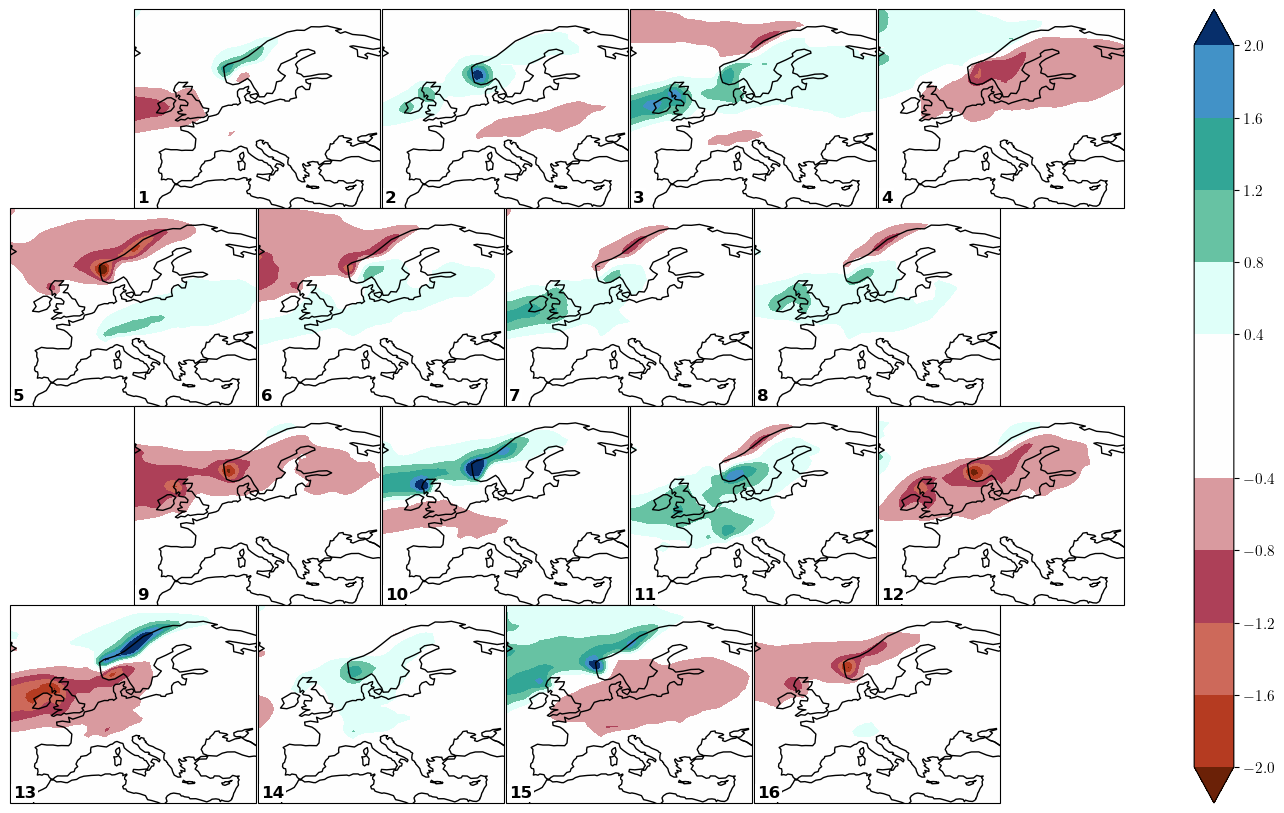

In [11]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp, mask, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [12]:
da_T = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/TS/historical/anom.zarr").rename({"member_id": "member"})
da_T["time"] = da_T.indexes["time"].to_datetimeindex()
da_T = extract(da_T, "all", None, -15, 40, 30, 75)
da_T = da_T.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
da_T = compute(da_T["TS"], progress_flag=True)

In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


[########################################] | 100% Completed | 11.52 s


100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


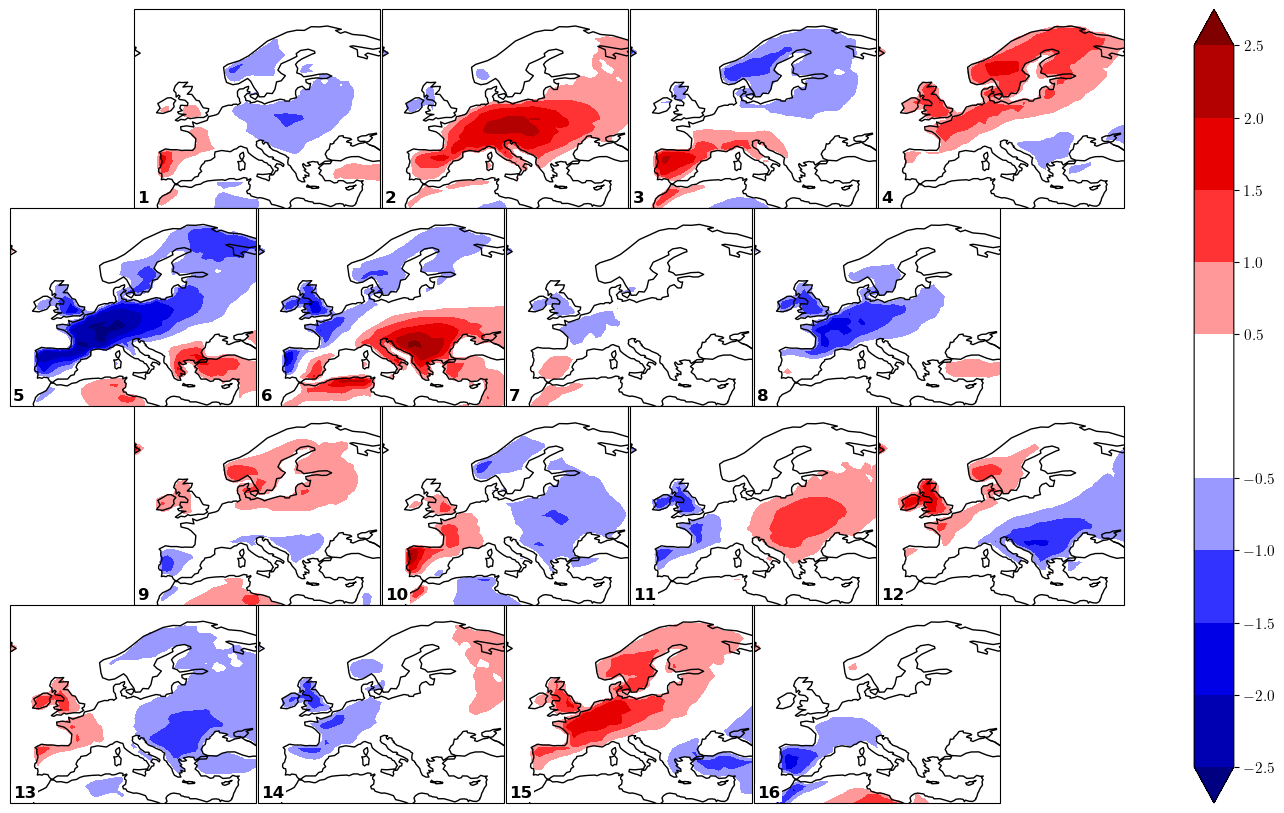

In [13]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T), numbering=True)
_ = clu.add_any_contour_from_mask(da_T, mask, cmap=colormaps.BlWhRe, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [2]:
from jetutils.definitions import KAPPA, RADIUS, compute
import xarray as xr
import numpy as np
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
ds_cesm["theta"] = (ds_cesm["t"] * (1000 / ds_cesm["lev"]) ** KAPPA).astype(np.float32)
ds_cesm = ds_cesm.drop_vars("t")
# dh = DataHandler.from_basepath_and_da("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/results", ds_cesm)
# exp = JetFindingExperiment(dh)
# all_jets_one_df = exp.find_jets()
# props_as_df = exp.props_as_df()

In [ ]:
from jetutils.definitions import KAPPA, RADIUS, compute
import xarray as xr
ds_cesm = ds_cesm.assign_coords(
    {
        "x": np.radians(ds_cesm["lon"]) * RADIUS,
        "y": RADIUS
        * np.log(
            (1 + np.sin(np.radians(ds_cesm["lat"])) / np.cos(np.radians(ds_cesm["lat"])))
        ),
    }
)
vort1 = compute(ds_cesm["v"].differentiate("x") - ds_cesm["u"].differentiate("y"), progress_flag=True)

[########################################] | 100% Completed | 82.77 s


In [ ]:
ds_cesm["u"].metpy.units

<Unit('meter / second')>

In [91]:
np.round(vort1.lat[[0, -1]], 2)

<xarray.DataArray 'lat' (lat: 2)> Size: 8B
array([15.55, 79.63], dtype=float32)
Coordinates:
  * lat      (lat) float32 8B 15.55 79.63
    y        (lat) float32 8B 1.564e+06 1.189e+07
Attributes:
    long_name:    latitude
    units:        degrees_north
    _metpy_axis:  y,latitude

In [ ]:
lat = vort1.lat.values
dl = round(lat[1] - lat[0], 2)
newlat = np.arange(lat[0], lat[-1] + dl, dl)
vort1 = vort1.assign_coords(lat=newlat)

array([15.55   , 16.49235, 17.43471, 18.37706, 19.31941, 20.26176,
       21.20412, 22.14647, 23.08882, 24.03118, 24.97353, 25.91588,
       26.85823, 27.80059, 28.74294, 29.68529, 30.62765, 31.57   ,
       32.51235, 33.4547 , 34.39706, 35.33941, 36.28176, 37.22411,
       38.16647, 39.10882, 40.05117, 40.99353, 41.93588, 42.87823,
       43.82058, 44.76294, 45.70529, 46.64764, 47.59   , 48.53235,
       49.4747 , 50.41705, 51.35941, 52.30176, 53.24411, 54.18647,
       55.12882, 56.07117, 57.01352, 57.95588, 58.89823, 59.84058,
       60.78294, 61.72529, 62.66764, 63.60999, 64.55235, 65.4947 ,
       66.43706, 67.37941, 68.32176, 69.26411, 70.20647, 71.14882,
       72.09117, 73.03352, 73.97588, 74.91823, 75.86058, 76.80293,
       77.74529, 78.68764, 79.63   ], dtype=float32)

In [104]:
import wavebreaking 
wavebreaking.calculate_cutoffs(vort1[0])

ValueError: No regular grid found for dimension lat.

In [75]:
from metpy.units import units
np.linalg.norm(vort1 / units.seconds - vort2) / vort1.data.size

np.float64(3.141474363059356e-08)

In [44]:
vort2 = mcalc.vorticity(ds_cesm["u"].isel(time=0), ds_cesm["v"].isel(time=0)).compute()

In [ ]:
ds_cesm["v"].differentiate("lon") - ds_cesm["u"].differentiate("lat")

<xarray.DataArray (member: 49, time: 14600, lat: 69, lon: 97)> Size: 19GB
dask.array<sub, shape=(49, 14600, 69, 97), dtype=float32, chunksize=(1, 100, 69, 97), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 276B 15.55 16.49 17.43 18.38 ... 77.75 78.69 79.63
  * lon      (lon) float32 388B -80.0 -78.75 -77.5 -76.25 ... 37.5 38.75 40.0
  * member   (member) <U15 3kB 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time     (time) object 117kB 1970-01-01 12:00:00 ... 2009-12-31 12:00:00